In [1]:
from servicex import ServiceXDataset
from coffea.processor.servicex import DataSource, Analysis
from coffea.processor.servicex import DaskExecutor
from func_adl_servicex import ServiceXSourceXAOD 

import matplotlib.pyplot as plt

from coffea import hist, processor
from IPython.display import display, update_display, HTML

In [2]:
dids = ['mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00']
datasets = [
    ServiceXDataset(did, backend_name='atlas_xaod')
    for did in dids
]

In [3]:
leptons_per_event_query = ServiceXSourceXAOD('dummy_dataset') \
        .Select(lambda e: e.Electrons("Electrons")) \
        .Select(lambda eles: eles.Where(lambda e: e.pt()/1000.0 > 30.0)) \
        .Select(lambda eles: eles.Where(lambda e: abs(e.eta()) < 2.5)) \
        .Where(lambda eles: len(eles) == 2) \
        .Select(lambda ls: {
                'electrons_pt': ls.Select(lambda e: e.pt()/1000.0),
                'electrons_eta': ls.Select(lambda e: e.eta()),
                'electrons_phi': ls.Select(lambda e: e.phi()),
                'electrons_mass': ls.Select(lambda e: e.m()/1000.0),
                'electrons_charge': ls.Select(lambda e: e.charge())
        })

Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.


In [4]:
datasource = DataSource(query=leptons_per_event_query, metadata={'dataset-nickname': 'Zee'}, datasets=datasets)

In [5]:
class Z_EEAnalysis(Analysis):
    @staticmethod
    def process(events):
        import awkward as ak
        from collections import defaultdict

        sumw = defaultdict(float)
        mass_hist = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("mass", "$Z_{ee}$ [GeV]", 60, 60, 120),
        )

        dataset = events.metadata['dataset-nickname']

        electrons = events.electrons

        # Form the invar mass, plot.
        cut = (ak.num(electrons) == 2)
        diele = electrons[cut][:, 0] + electrons[cut][:, 1]

        sumw[dataset] += len(events)
        mass_hist.fill(
            dataset=dataset,
            mass=diele.mass,
        )
        
        return {
            "sumw": sumw,
            "mass": mass_hist
        }

We create the analysis and executor. The `DaskExecutor` can be done two ways:

- `DaskExecutor()` which creates a local cluster. All data will be pulled down to the local machine via an `uproot.open`. This can be paiful depending on what your connection looks like.
- `DaskExecutor(client_addr="node.name.edu:8786")` which will attach to a remote `dask` cluster. This is particularly powerful if the `dask` cluster is located close to the `servicex` installation.

In [6]:
analysis = Z_EEAnalysis()
#executor = DaskExecutor(client_addr="localhost:8786")
executor = DaskExecutor()

This next method makes an updating plot, as the data appears. If you didn't want the fancy updating plot, you could do `await executor.execute(analysis, datasource)`, and you'd end up with the coffea dict when that cell completed.

{'sumw': defaultdict(<class 'float'>, {'Zee': 24000.0}), 'mass': <Hist (dataset,mass) instance at 0x1bc35633700>}


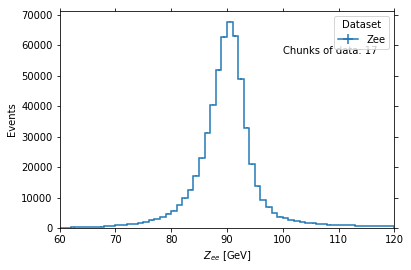

{'sumw': defaultdict(<class 'float'>, {'Zee': 74000.0}), 'mass': <Hist (dataset,mass) instance at 0x1bc35633700>}
{'sumw': defaultdict(<class 'float'>, {'Zee': 124000.0}), 'mass': <Hist (dataset,mass) instance at 0x1bc35633700>}
{'sumw': defaultdict(<class 'float'>, {'Zee': 249000.0}), 'mass': <Hist (dataset,mass) instance at 0x1bc35633700>}
{'sumw': defaultdict(<class 'float'>, {'Zee': 399000.0}), 'mass': <Hist (dataset,mass) instance at 0x1bc35633700>}
{'sumw': defaultdict(<class 'float'>, {'Zee': 549000.0}), 'mass': <Hist (dataset,mass) instance at 0x1bc35633700>}
{'sumw': defaultdict(<class 'float'>, {'Zee': 699000.0}), 'mass': <Hist (dataset,mass) instance at 0x1bc35633700>}
{'sumw': defaultdict(<class 'float'>, {'Zee': 849000.0}), 'mass': <Hist (dataset,mass) instance at 0x1bc35633700>}
{'sumw': defaultdict(<class 'float'>, {'Zee': 998800.0}), 'mass': <Hist (dataset,mass) instance at 0x1bc35633700>}
{'sumw': defaultdict(<class 'float'>, {'Zee': 1148800.0}), 'mass': <Hist (dataset

In [7]:
%matplotlib inline
async def plot_stream(accumulator_stream):
  global first
  fig, axes = plt.subplots()
  first = True


  count = 0
  async for coffea_info in accumulator_stream:
    print(coffea_info)
    hist.plot1d(coffea_info['mass'], ax=axes)

    count += 1
    plt.text(0.95, 0.8, f'Chunks of data: {count}', horizontalalignment='right', transform=axes.transAxes)

    # Either display it or update a previous version of the plot
    if first:
        display(fig, display_id='mass_update')
        first = False
    else:
        update_display(fig, display_id='mass_update')
  return coffea_info

await plot_stream(executor.execute(analysis, datasource))
plt.close()  # Prevents another copy of the plot showing up in the notebook